# Advanced Tracking with DIPY

In this notebook, we explore advanced tractography methods, including **anatomically-constrained tracking (ACT, CMC)**, **Particle Filtering Tractography (PFT)**, **deterministic LocalTracking with ACT**, and **Parallel Transport Tractography (PTT).**

#### 

**Author**: Monika Doerig

**Date**: 5 Dec 2025

### Citation and Resources:

#### Tools included in this workflow
__DIPY:__
- Garyfallidis, E., Brett, M., Amirbekian, B., Rokem, A., van der Walt, S., Descoteaux, M., Nimmo-Smith, I., & Dipy Contributors (2014). Dipy, a library for the analysis of diffusion MRI data. Frontiers in neuroinformatics, 8, 8. [https://doi.org/10.3389/fninf.2014.00008](https://doi.org/10.3389/fninf.2014.00008)

__FURY - Free Unified Rendering in Python:__
- Eleftherios Garyfallidis, Serge Koudoro, Javier Guaje, Marc-Alexandre Côté, Soham Biswas, David Reagan, Nasim Anousheh, Filipi Silva, Geoffrey Fox, and Fury Contributors. "FURY: advanced scientific visualization." Journal of Open Source Software 6, no. 64 (2021): 3384. [https://doi.org/10.21105/joss.03384](https://doi.org/10.21105/joss.03384)
- [FURY Home](https://fury.gl/latest/index.html)



#### Educational resources
- [Fiber Tracking Tutorials DIPY (v1.9.0)](https://docs.dipy.org/1.9.0/examples_built/fiber_tracking/index.html)


## Introduction 

Advanced tractography extends local fiber tracking by incorporating anatomical constraints and more sophisticated streamline propagation strategies. These methods aim to improve the anatomical plausibility and geometric consistency of reconstructed pathways.

This notebook builds on the foundational workflow from the first notebook and demonstrates how to incorporate anatomical information and advanced propagation techniques to produce more biologically plausible tractography results.

### Goal

Gain practical understanding of anatomically-constrained and advanced tractography workflows in DIPY, from tissue segmentation to streamline generation.

#### What You Will Explore

- Anatomically-informed tracking using tissue segmentation maps (ACT / CMC).

- Particle Filtering Tractography (PFT) — probabilistic tractography constrained by tissue anatomy.

- Parallel Transport Tractography (PTT) — smooth propagation of streamlines with curvature control.

## Install and import python libraries

In [1]:
%%capture 
! pip install fury==0.11.0 dipy==1.11.0 vtk==9.5.2

In [2]:
# Import the necessary libraries
import numpy as np
import matplotlib.pyplot as plt
import nibabel as nib
from IPython.display import  Image

from dipy.tracking.stopping_criterion import CmcStoppingCriterion, ActStoppingCriterion, ThresholdStoppingCriterion
from dipy.core.gradients import gradient_table
from dipy.data import get_fnames, default_sphere, get_sphere
from dipy.direction import ProbabilisticDirectionGetter, PTTDirectionGetter
from dipy.io.gradients import read_bvals_bvecs
from dipy.io.image import load_nifti, load_nifti_data
from dipy.io.stateful_tractogram import Space, StatefulTractogram
from dipy.io.streamline import save_trk
from dipy.reconst.csdeconv import (ConstrainedSphericalDeconvModel,
                                   auto_response_ssst)
from dipy.reconst.shm import CsaOdfModel
from dipy.tracking.local_tracking import (LocalTracking,
                                          ParticleFilteringTracking)
from dipy.tracking.streamline import Streamlines
from dipy.tracking import utils
from dipy.viz import window, actor, colormap, has_fury

## Load Stanford HARDI dataset from Stanford provided by DIPY

In [3]:
hardi_fname, hardi_bval_fname, hardi_bvec_fname = get_fnames(name='stanford_hardi')
label_fname = get_fnames(name='stanford_labels')
f_pve_csf, f_pve_gm, f_pve_wm = get_fnames(name='stanford_pve_maps')

data, affine, hardi_img = load_nifti(hardi_fname, return_img=True)
labels = load_nifti_data(label_fname)
bvals, bvecs = read_bvals_bvecs(hardi_bval_fname, hardi_bvec_fname)
gtab = gradient_table(bvals, bvecs=bvecs)

pve_csf_data = load_nifti_data(f_pve_csf)
pve_gm_data = load_nifti_data(f_pve_gm)
pve_wm_data, _, voxel_size = load_nifti(f_pve_wm, return_voxsize=True)

shape = labels.shape

## Fitting a Constrained Spherical Deconvolution (CSD) Model

To reconstruct white matter pathways, we first need to estimate the **local fiber directions** within each voxel.
In diffusion MRI, water molecules diffuse more easily along axons than across them — this directional dependence can be modeled to infer underlying fiber orientations.

- Estimates the Fiber Orientation Distribution (FOD) by deconvolving the diffusion signal with a single-fiber response function. The FOD is represented using spherical harmonics (SH).
- Resolves multiple distinct fiber populations per voxel (crossings, branchings). 
- Produces sharper, more accurate orientation peaks, improving both deterministic and probabilistic tractography  

In [4]:
response, ratio = auto_response_ssst(gtab, data, roi_radii=10, fa_thr=0.7)
csd_model = ConstrainedSphericalDeconvModel(gtab, response)
csd_fit = csd_model.fit(data, mask=pve_wm_data)

### Creating a probabilistic direction getter

We use probabilistic tracking, where tracking directions at each step are sampled from the orientation distribution (FOD) rather than always following the most likely direction. This allows streamlines to explore multiple plausible trajectories in areas of crossing or branching fibers. s.

In [5]:
# Probabilistic direction getting for fiber tracking
# Uses on-the-fly SH-to-PMF conversion for memory efficiency
dg = ProbabilisticDirectionGetter.from_shcoeff(csd_fit.shm_coeff,
                                               max_angle=20.,
                                               sphere=default_sphere,
                                               sh_to_pmf=True)

## Defining seeds
Seeds specify where streamlines begin. Here we place seeds within the corpus callosum label and further restrict them to voxels with sufficient white matter partial volume (PVE > 0.5), ensuring that tracking begins in anatomically valid tissue.

In [6]:
seed_mask = (labels == 2)
seed_mask[pve_wm_data < 0.5] = 0
seeds = utils.seeds_from_mask(seed_mask, affine, density=2)

## CMC Stopping Criterion

The Continuous Map Criterion (CMC) uses tissue partial volume probabilities (WM/GM/CSF) from anatomical segmentation to guide termination. At each step, PVE values are interpolated at the current position, and a probabilistic rule determines whether continuing the streamline is anatomically plausible. CMC allows gradual boundary transitions (e.g., WM → GM), supporting softer and more realistic anatomical termination.


Here, we initialize the CMC stopping criterion using the tissue partial volume maps. The average `voxel_size` helps scale tracking relative to anatomical resolution, while the `step_size` determines how far the streamline advances at each step. Using the WM, GM, and CSF PVE maps, the CMC criterion evaluates the anatomical plausibility of continuing the streamline as it moves through tissue boundaries.

In [7]:
voxel_size = np.average(voxel_size[1:4])
step_size = 0.2

cmc_criterion = CmcStoppingCriterion.from_pve(pve_wm_data,
                                              pve_gm_data,
                                              pve_csf_data,
                                              step_size=step_size,
                                              average_voxel_size=voxel_size)

## ACT Stopping CriterionAnatomically-Constrained Tractography (ACT) uses PVE maps as well, but with discrete classification rather than probabilistic transitions. The 'include_map' specifies where it is valid for streamlines to end (e.g., gray matter), while the `exclude_map` defines invalid termination regions (e.g., CSF). Background areas should also be added to the `include_map` to allow streamlines to exit through structures such as the brainstem. As with CMC, ACT uses trilinear interpolation at each tracking position.

In the following implementation, we construct the ACT stopping maps by defining regions where streamlines are permitted to terminate (include_map) and regions where termination is not allowed (exclude_map). To handle brain boundaries correctly, we incorporate a background mask identifying outside-brain voxels, ensuring that streamlines may terminate naturally when exiting the brain (e.g., through the brainstem) rather than stopping prematurely at tissue edges. We visualize the resulting maps to verify their correct spatial definitions..

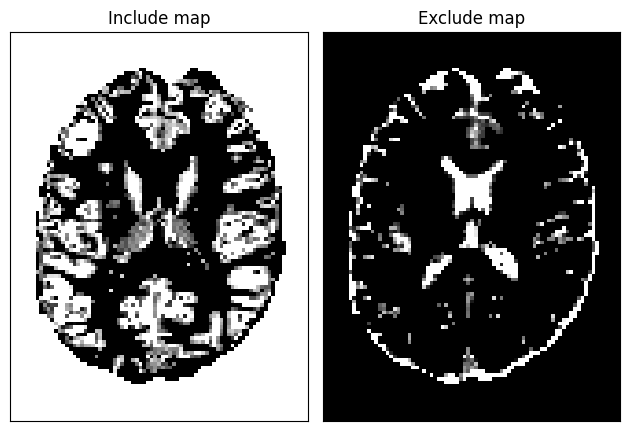

In [8]:
background = np.ones(pve_gm_data.shape)
background[(pve_gm_data + pve_wm_data + pve_csf_data) > 0] = 0

include_map = pve_gm_data #gray matter partial volume estimation (PVE) map
include_map[background > 0] = 1
exclude_map = pve_csf_data #corticospinal fluid PVE map

act_criterion = ActStoppingCriterion(include_map, exclude_map)

fig = plt.figure()
plt.subplot(121)
plt.xticks([])
plt.yticks([])
plt.imshow(include_map[:, :, data.shape[2] // 2].T, cmap='gray',
           origin='lower', interpolation='nearest')
plt.title('Include map')

plt.subplot(122)
plt.xticks([])
plt.yticks([])
plt.imshow(exclude_map[:, :, data.shape[2] // 2].T, cmap='gray',
           origin='lower', interpolation='nearest')
plt.title('Exclude map')

fig.tight_layout()
fig.savefig('act_maps.png')

Both methods can be combined with Particle Filtering Tractography.

## Anatomically-Constrained Tractography

### Probabilistic: Particle Filtering Tractography (PFT)
Particle Filtering Tractography is an advanced local tracking method that uses multiple hypothetical “particles” to improve robustness in complex white matter regions. It can continue streamlines past minor interruptions or ambiguous fiber orientations, guided by anatomical stopping criteria such as CMC or ACT.

__Key PFT parameters:__

- `pft_back_tracking_dist`: distance (mm) to backtrack if the tractography temporarily stops in WM or CSF.

- `pft_front_tracking_dist`: distance (mm) to continue forward after a stopping event.

- `particle_count`: number of samples used in the particle filtering algorithm; higher counts increase robustness at the cost of computation.

- `min_wm_pve_before_stopping`: ensures streamlines only terminate in GM after reaching a minimum WM partial volume. This is especially useful when seeding near WM-GM boundaries or in subcortical GM, as it allows streamlines to reach deep white matter before terminating.ing.

#### Example using CMC:

In [9]:
pft_streamline_gen = ParticleFilteringTracking(dg,
                                               cmc_criterion,
                                               seeds,
                                               affine,
                                               max_cross=1,
                                               step_size=step_size,
                                               maxlen=1000,
                                               pft_back_tracking_dist=2,
                                               pft_front_tracking_dist=1,
                                               particle_count=15,
                                               return_all=False,
                                               min_wm_pve_before_stopping=1)
streamlines_pft = Streamlines(pft_streamline_gen)

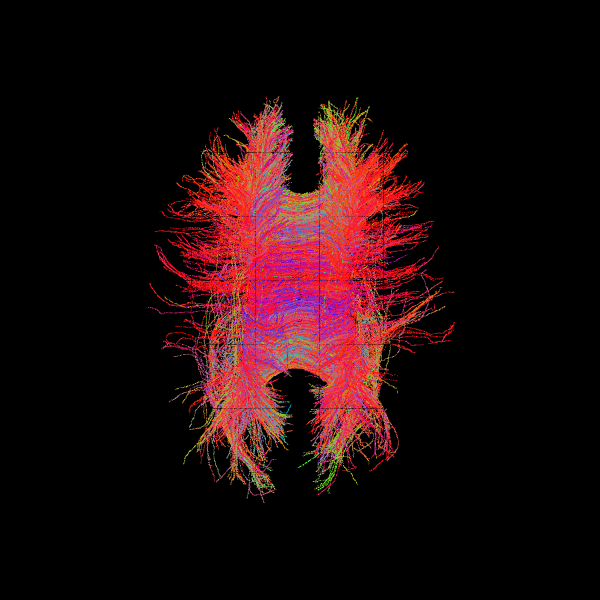

In [10]:
scene = window.Scene()
scene.add(actor.line(streamlines_pft, colors=colormap.line_colors(streamlines_pft)))
window.record(scene=scene, out_path='tractogram_pft.png',
              size=(600, 600))

Image("tractogram_pft.png")

### Deterministic: LocalTracking

Deterministic LocalTracking uses anatomical stopping criteria (e.g., ACT) to generate streamlines following the most probable local fiber orientation without probabilistic sampling.

#### Example using ACT:

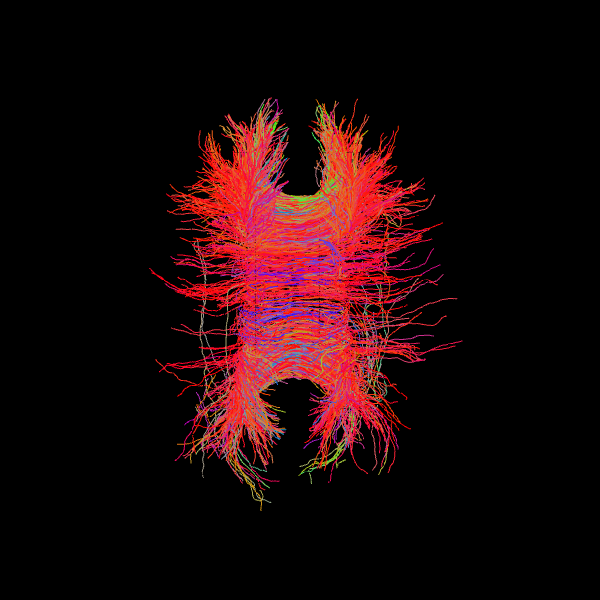

In [11]:
streamline_generator = LocalTracking(dg,
                                     act_criterion,
                                     seeds,
                                     affine,
                                     step_size=.5,
                                     return_all=False)
streamlines = Streamlines(streamline_generator)

scene = window.Scene()
scene.add(actor.line(streamlines, colors=colormap.line_colors(streamlines)))
window.record(scene=scene, out_path='tractogram_deterministic_act.png',
              size=(600, 600))

Image("tractogram_deterministic_act.png")

> Both probabilistic PFT and deterministic LocalTracking generate anatomically-constrained streamlines. PFT explores multiple possible paths per seed and is more robust in regions with complex fiber configurations, while deterministic LocalTracking follows the single most likely path according to the local orientation distribution.



## Parallel Transport Tractography
So far, we have explored anatomically-constrained tractography methods (CMC, ACT) with probabilistic and deterministic tracking. Another approach to improve streamline smoothness and stability is **Parallel Transport Tractography (PTT)**.

PTT transports directional information along the evolving path to reduce abrupt changes in orientation. Unlike ACT or CMC, PTT itself does not impose anatomical constraints; any anatomical plausibility comes from the stopping criterion used (e.g., a white-matter mask or FA threshold). In this example, we pair PTT with a threshold-based stopping criterion derived from **Generalized Fractional Anisotropy (GFA)**.

GFA is a diffusion MRI metric analogous to FA, but derived from the orientation distribution function (ODF) rather than a simple diffusion tensor. It reflects the degree of directional diffusion within a voxel and is particularly useful in regions with complex fiber configurations, such as crossing or branching fibers.


In [12]:
csa_model = CsaOdfModel(gtab, sh_order_max=6)
gfa = csa_model.fit(data, mask=pve_wm_data).gfa
stopping_criterion = ThresholdStoppingCriterion(gfa, .25)

In [13]:
sphere = get_sphere(name='repulsion200')
fod = csd_fit.odf(sphere)
pmf = fod.clip(min=0)
ptt_dg = PTTDirectionGetter.from_pmf(pmf, max_angle=15, probe_length=0.5,
                                     sphere=sphere)

# Parallel Transport Tractography
streamline_generator = LocalTracking(direction_getter=ptt_dg,
                                     stopping_criterion=stopping_criterion,
                                     seeds=seeds,
                                     affine=affine,
                                     step_size=0.2)

streamlines_ptt = Streamlines(streamline_generator)

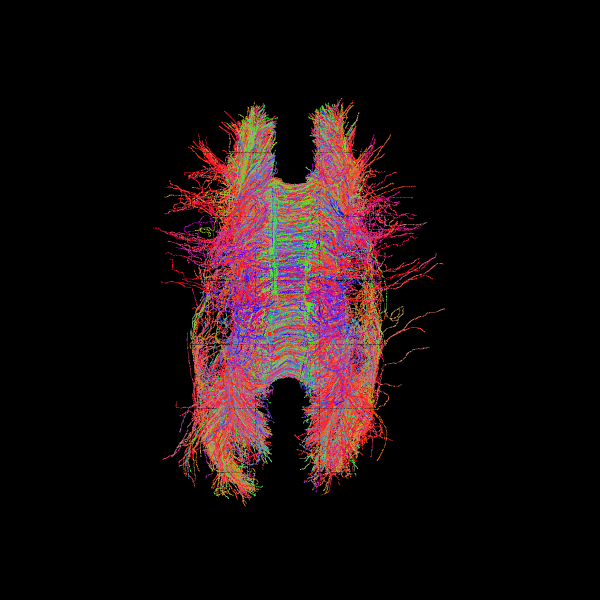

In [14]:
scene = window.Scene()
scene.add(actor.line(streamlines_ptt, colors=colormap.line_colors(streamlines_ptt)))
window.record(scene=scene, out_path='tractogram_ptt_dg_pmf.png',
                  size=(600, 600))
Image('tractogram_ptt_dg_pmf.png')

In [15]:
print("PFT streamlines:", len(streamlines_pft))
print("Deterministic ACT streamlines:", len(streamlines))
print("PTT streamlines:", len(streamlines_ptt))

PFT streamlines: 2809
Deterministic ACT streamlines: 1142
PTT streamlines: 3155


#### Dependencies in Jupyter/Python
- Using the package [watermark](https://github.com/rasbt/watermark) to document system environment and software versions used in this notebook


In [16]:
%load_ext watermark

%watermark
%watermark --iversions

Last updated: 2026-01-19T13:08:29.081727+00:00

Python implementation: CPython
Python version       : 3.13.9
IPython version      : 9.7.0

Compiler    : GCC 14.3.0
OS          : Linux
Release     : 5.15.0-164-generic
Machine     : x86_64
Processor   : x86_64
CPU cores   : 32
Architecture: 64bit

IPython   : 9.7.0
dipy      : 1.11.0
fury      : 0.11.0
matplotlib: 3.10.8
nibabel   : 5.3.3
numpy     : 2.3.5

